In [1]:
import os
import copy
import torch 
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19
from torch import nn,optim
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset,SubsetRandomSampler
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!unzip Computer_Vision_Users.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./train/white/117041094.jpg  
  inflating: ./train/white/116998153.jpg  
  inflating: ./train/white/117023613.jpg  
  inflating: ./train/white/117109595.jpg  
  inflating: ./train/white/116980795.jpg  
  inflating: ./train/white/117023893.jpg  
  inflating: ./train/white/117038903.jpg  
  inflating: ./train/white/105522952.jpg  
  inflating: ./train/white/105649840.jpg  
  inflating: ./train/white/105351875.jpg  
  inflating: ./train/white/105560394.jpg  
  inflating: ./train/white/117120345.jpg  
  inflating: ./train/white/117061022.jpg  
  inflating: ./train/white/117081757.jpg  
  inflating: ./train/white/117102861.jpg  
  inflating: ./train/white/116995598.jpg  
  inflating: ./train/white/117089104.jpg  
  inflating: ./train/white/117103920.jpg  
  inflating: ./train/white/105433846.jpg  
  inflating: ./train/white/115248566.jpg  
  inflating: ./train/white/116979498.jpg  
  inflating: ./train/white/117085582.jpg  
  i

In [2]:
vgg19_model = vgg19().to(DEVICE)
# vggClassifier=copy.deepcopy(vgg19_model.classifier)
# vggClassifier=nn.Sequential(nn.Flatten(1),vggClassifier).to(DEVICE)
# del vgg19_model.classifier
# vggFeatures=nn.Sequential(vgg19_model.features,vgg19_model.avgpool).to(DEVICE)
# # for param in vggClassifier.parameters():
# #   param.requires_grad = False
# for param in vggFeatures.parameters():
#   param.requires_grad = False
# # vggClassifier.eval()
# vgg={'feat':vggFeatures,'cls':vggClassifier}
lastPart=nn.Sequential(nn.Dropout(),nn.Linear(1000,256),nn.ReLU(),
                       nn.Linear(256,64),nn.ReLU(),
                       nn.Dropout(),nn.Linear(64,12),nn.ReLU()).to(DEVICE)
vgg19_model.eval()
# vggFeatures.eval()
print('-')

-


In [4]:
BATCH_SIZE=32
EPOCHS=15

In [5]:
trainDS=ImageFolder('train',transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
indices = list(range(len(trainDS)))
split = int(np.floor(0.1 * len(trainDS)))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
trainDL=DataLoader(trainDS,batch_size=BATCH_SIZE,sampler=train_sampler)
validDL=DataLoader(trainDS,batch_size=BATCH_SIZE,sampler=valid_sampler)

In [6]:
optimizer=optim.Adam(list(vgg19_model.parameters())+list(lastPart.parameters()),lr=0.001)

In [7]:
epochs_train_losses=[]
epochs_valid_losses=[]

Train ,Epoch#1 ,batch 1/175.0 ,avg-loss: 2.4835033416748047
Train ,Epoch#1 ,batch 11/175.0 ,avg-loss: 93.540710514242
Train ,Epoch#1 ,batch 21/175.0 ,avg-loss: 50.1775747026716
Train ,Epoch#1 ,batch 31/175.0 ,avg-loss: 34.79175485334089
Train ,Epoch#1 ,batch 41/175.0 ,avg-loss: 26.909919448015167
Train ,Epoch#1 ,batch 51/175.0 ,avg-loss: 22.119512819776347
Train ,Epoch#1 ,batch 61/175.0 ,avg-loss: 18.89993351795634
Train ,Epoch#1 ,batch 71/175.0 ,avg-loss: 16.58670217890135
Train ,Epoch#1 ,batch 81/175.0 ,avg-loss: 14.843744669431521
Train ,Epoch#1 ,batch 91/175.0 ,avg-loss: 13.483623601578094
Train ,Epoch#1 ,batch 101/175.0 ,avg-loss: 12.391426865417179
Train ,Epoch#1 ,batch 111/175.0 ,avg-loss: 11.494891411549336
Train ,Epoch#1 ,batch 121/175.0 ,avg-loss: 10.748227872139166
Train ,Epoch#1 ,batch 131/175.0 ,avg-loss: 10.115049394942423
Train ,Epoch#1 ,batch 141/175.0 ,avg-loss: 9.5704959250511
Train ,Epoch#1 ,batch 151/175.0 ,avg-loss: 9.100549593666532
Train ,Epoch#1 ,batch 161/175.0

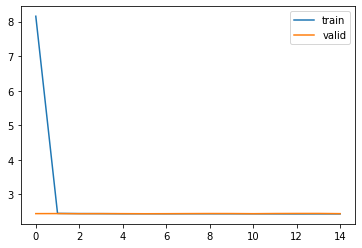

In [8]:
vgg19_model.train()
lastPart.train()
train_batch_cnt=len(trainDS)*.9//BATCH_SIZE
valid_batch_cnt=len(trainDS)*.1//BATCH_SIZE
for epoch in range(EPOCHS):
  batches_train_losses=[]
  for num,batch in enumerate(trainDL):
    vgg19_model.zero_grad()
    lastPart.zero_grad()
    x=vgg19_model(batch[0].to(DEVICE))
    x=lastPart(x)
    loss=F.cross_entropy(x,batch[1].to(DEVICE))
    loss.backward()
    optimizer.step()
    batches_train_losses+=[loss.item()]
    if num%10==0:
      avg_loss=np.mean(batches_train_losses)
      print('Train ,Epoch#{} ,batch {}/{} ,avg-loss: {}'.format(epoch+1,num+1,train_batch_cnt,avg_loss))
  epoch_loss=np.mean(batches_train_losses)
  print('Train ,Epoch#{} ,loss:{}'.format(epoch+1,epoch_loss))
  epochs_train_losses+=[epoch_loss]
  vgg19_model.eval()
  lastPart.eval()
  batches_test_losses=[]
  for num,batch in enumerate(validDL):
    with torch.no_grad():
      x=vgg19_model(batch[0].to(DEVICE))
      x=lastPart(x)
      loss=F.cross_entropy(x,batch[1].to(DEVICE))
    batches_test_losses+=[loss.item()]
    if num%10==0:
      avg_loss=np.mean(batches_test_losses)
      print('Test ,batch {}/{} ,avg-loss: {}'.format(num+1,valid_batch_cnt,avg_loss))
  vgg19_model.train()
  lastPart.train()
  epoch_loss=np.mean(batches_test_losses)
  epochs_valid_losses+=[epoch_loss]
  print('Test ,Epoch#{} ,loss:{}'.format(epoch+1,epoch_loss))
plt.plot(epochs_train_losses)
plt.plot(epochs_valid_losses)
plt.legend(['train','valid'],loc='upper right')
plt.show()

In [ ]:
class TestDataset(Dataset):
  def __init__(self,path='.'):
    super(Dataset).__init__()
    self.sample_files=os.listdir(path)
    self.path=path
    self.tf=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  def __len__(self):
    return len(self.sample_files)
  def __getitem__(self,i):
    image=Image.open(self.path+'/'+self.sample_files[i])
    return self.sample_files[i],self.tf(image)

In [ ]:
vgg19_model.eval()
lastPart.eval()
testDS=TestDataset('test')
testDL=DataLoader(testDS,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
results=[]
for num,batch in enumerate(testDL):
  with torch.no_grad():
    x=vgg19_model(batch[1].to(DEVICE))
    x=lastPart(x)
  preds=torch.argmax(x,dim=1).cpu().numpy()
  fnames=list(batch[0])
  results+=list(zip(fnames,preds))
  if num%10==0:
    print(num)

0
10
20


In [ ]:
for i  in range(len(results)):
  if results[i][1]==0:
    results[i]=(results[i][0],8)
  elif results[i][1]==1:
    results[i]=(results[i][0],12)
  elif results[i][1]==2:
    results[i]=(results[i][0],10)
  elif results[i][1]==3:
    results[i]=(results[i][0],11)
  elif results[i][1]==4:
    results[i]=(results[i][0],7)
  elif results[i][1]==5:
    results[i]=(results[i][0],4)
  elif results[i][1]==6:
    results[i]=(results[i][0],1)
  elif results[i][1]==7:
    results[i]=(results[i][0],2)
  elif results[i][1]==8:
    results[i]=(results[i][0],9)
  elif results[i][1]==9:
    results[i]=(results[i][0],6)
  elif results[i][1]==10:
    results[i]=(results[i][0],5)
  else:
    results[i]=(results[i][0],3)

In [ ]:
res=pd.DataFrame(results,columns=['file_name','color_id'])
res.to_csv('res.csv',index=False)